# Exploring the UTx000 Extension EMA Data
(See the [GH repo](https://github.com/intelligent-environments-lab/utx000))

# EMA Summary
In this notebook we look at the various EMA data with a focus on the sleep data from the morning EMAs.

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Package Import

In [2]:
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
import numpy as np
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from datetime import datetime, timedelta
import math

## Data Import

### Morning Survey Data

In [3]:
sleep_survey = pd.read_csv('../data/processed/beiwe-morning_ema-ux_s20.csv',
                           index_col=0,parse_dates=True,infer_datetime_format=True)
sleep_survey.head()

,beiwe,content,stress,lonely,sad,energy,tst,sol,naw,restful,redcap,beacon
timestamp,,,,,,,,,,,,
2020-05-13 09:10:27,qh34m4r9,3,0.0,0.0,0.0,1.0,8.0,20.0,2.0,3.0,68,19.0
2020-05-13 09:15:49,awa8uces,0.0,2.0,1.0,1.0,1.0,2.0,10.0,3.0,1.0,28,26.0
2020-05-13 09:42:19,xxvnhauv,1,1.0,1.0,3.0,0.0,6.0,30.0,3.0,1.0,21,22.0
2020-05-13 09:43:27,rvhdl2la,1,1.0,2.0,3.0,0.0,5.3,5.0,2.0,2.0,29,NaN
2020-05-13 10:11:51,q5y11ytm,3,1.0,0.0,1.0,2.0,2.0,10.0,0.0,0.0,48,NaN


### Evening Survey Data

In [4]:
evening_survey = pd.read_csv('../data/processed/beiwe-evening_ema-ux_s20.csv',
                             index_col=0,parse_dates=True,infer_datetime_format=True)
evening_survey.head()

,beiwe,content,stress,lonely,sad,energy,redcap,beacon
timestamp,,,,,,,,
2020-05-13 19:00:23,awa8uces,1.0,1,1.0,3,2,28,26.0
2020-05-13 19:21:32,lkkjddam,0.0,2,3.0,1,0,12,21.0
2020-05-13 19:30:38,rvhdl2la,2.0,1,0.0,0,1,29,NaN
2020-05-13 20:07:04,xxvnhauv,1.0,3,1.0,2,0,21,22.0
2020-05-13 20:25:07,xdbdrk6e,2.0,1,2.0,1,3,23,24.0


### Weekly Survey Data

In [5]:
weekly_survey = pd.read_csv('../data/processed/beiwe-weekly_ema-ux_s20.csv',index_col=0,parse_dates=True)
weekly_survey.head()

,beiwe,upset,unable,stressed,confident,your_way,cope,able,top,angered,overcome,redcap,beacon
timestamp,,,,,,,,,,,,,
2020-05-14 11:29:37,hcpu5myv,2,2.0,2,2,2.0,1,2,1,1,1,27,41.0
2020-05-16 06:28:30,shi1ykro,2,0.0,3,3,2.0,0,4,1,0,0,44,NaN
2020-05-16 06:40:30,9xmhtq74,0,0.0,2,4,4.0,0,3,3,0,0,59,17.0
2020-05-16 07:38:51,awa8uces,3,3.0,4,2,2.0,3,2,1,1,4,28,26.0
2020-05-16 07:46:55,rvhdl2la,2,2.0,3,2,2.0,3,1,2,3,2,29,NaN


# Survey Data Overview
Here we get a sense of the data we are using for the EMAs

## Available Data
We can take a look at how many submission for a particular questions were made in addition to how many participants submitted at least one answer to that category.

In [32]:
for df, survey_type in zip([sleep_survey,evening_survey,weekly_survey],["Morning","Evening","Weekly"]):
    print(f"Working for {survey_type} EMAs - Total of",len(df))
    for col in df.columns:
        if col not in ["beiwe","DoW"]:
            temp = df[["beiwe",col]]
            temp.dropna(subset=[col],inplace=True)
            n_responses = len(temp)
            n_pts = len(temp["beiwe"].unique())
            print(f"\t{n_responses}\t{col}\t{n_pts} participants")

Working for Morning EMAs - Total of 2470
	2470	content	62 participants
	2470	stress	62 participants
	2469	lonely	62 participants
	2470	sad	62 participants
	2470	energy	62 participants
	2457	tst	62 participants
	2470	sol	62 participants
	2469	naw	62 participants
	2470	restful	62 participants
	2470	redcap	62 participants
	1371	beacon	27 participants
	2470	date	62 participants
	2470	WoY	62 participants
	2470	Survey	62 participants
	2470	hour	62 participants
Working for Evening EMAs - Total of 2460
	2443	content	62 participants
	2460	stress	62 participants
	2459	lonely	62 participants
	2460	sad	62 participants
	2460	energy	62 participants
	2460	redcap	62 participants
	1351	beacon	27 participants
	2460	date	62 participants
	2460	WoY	62 participants
	2460	Survey	62 participants
	2460	hour	62 participants
Working for Weekly EMAs - Total of 793
	793	upset	62 participants
	791	unable	62 participants
	793	stressed	62 participants
	793	confident	62 participants
	792	your_way	62 participants
	793	

## Submission
Various aspects related to the participants' submissions are summarized below

### Time Frame

It is important to note that the survey period has been restricted from datetime(2020,5,13) to datetime(2020,9,1) since the corrected surveys were sent out on May 13th and the first appointment to return devices was on September 1st. We can check that assumption here by checking the earliest and latest date:

In [7]:
temp = sleep_survey.sort_index()
print("Earliest Submission:", temp.index[0])
print("Last Submission", temp.index[-1])
first_date = temp.index[0] - timedelta(days=1)
end_date = temp.index[-1]

Earliest Submission: 2020-05-13 09:10:27
Last Submission 2020-09-01 21:45:26


<div class="alert alert-block alert-success">
    Submission dates match the study window
</div>

### Possible Submissions
Based on the time frame of EMA submission, we can determine the maximum amount of surveys that might have been submitted by counting the weekdays that those EMAs were sent out on.

In [8]:
maxDailySurveys = np.busday_count(first_date.date(), end_date.date(), weekmask='Mon Wed Fri Sun') + 1
print(f'Maximum \"Daily\" Surveys: {maxDailySurveys}')
maxWeeklySurveys = np.busday_count(first_date.date(), end_date.date(), weekmask='Sat')
print(f'Maximum Weekly Surveys: {maxWeeklySurveys}')

Maximum "Daily" Surveys: 65
Maximum Weekly Surveys: 16


In [9]:
def get_number_surveys_submitted(df):
    """
    Gets the number of submissions per participant
    """
    df.sort_values("beiwe",inplace=True)
    temp_dict = {"beiwe":[],"n":[]}
    new_df = pd.DataFrame()
    for pt in df['beiwe'].unique():
        survey_by_pt = df[df['beiwe'] == pt]
        # adding to original df
        survey_by_pt["n"] = len(survey_by_pt)
        new_df = new_df.append(survey_by_pt)
        # adding to new dictionary
        temp_dict["beiwe"].append(pt)
        temp_dict["n"].append(len(survey_by_pt))

    return new_df.sort_values("n",ascending=False), pd.DataFrame(temp_dict).sort_values("n",ascending=False)

Knowing these are the maximum possible submissions, now we can look at the total number of morning and evening survyes that were submitted by each participant.

In [49]:
def plot_total_submissions(morning=sleep_survey, evening=evening_survey, max_daily_surveys=maxDailySurveys, first_date=first_date, end_date=end_date, by_id="beiwe", save=False):
    """
    Plots the number of surveys submitted for morning and evening
    """
    fig, ax = plt.subplots(figsize=(16,5))
    temp_dict = {by_id:[],"orange":[],"black":[]}
    morning.sort_values(by_id,inplace=True)
    evening.sort_values(by_id,inplace=True)
    for df, color, size in zip([morning,evening],['orange','black'],[100,50]):
        # Looping through beacon participants only
        for beiwe in df[by_id].unique():
            survey_by_beiwe = df[df[by_id] == beiwe]
            survey_by_beiwe = survey_by_beiwe.sort_index()[first_date.date():end_date.date()]
            temp_dict[color].append(len(survey_by_beiwe))

    temp_dict[by_id] = morning[by_id].unique()
    df_to_plot = pd.DataFrame(temp_dict)
    df_to_plot[by_id] = df_to_plot[by_id].astype(str)
    df_to_plot.sort_values("orange",ascending=False,inplace=True)
    df_to_plot.set_index(by_id,inplace=True)
    for color, size, label in zip(df_to_plot.columns,[100,50],["Morning","Evening"]):
        # scattering number of surveys submitted per participant
        ax.scatter(df_to_plot.index,df_to_plot[color]/max_daily_surveys*100,s=size,color=color,label=label)
        
    # Average Line
    ax.axhline(np.mean(df_to_plot["black"])/max_daily_surveys*100,color="black",linewidth=2,linestyle="dashed")
    #print(np.mean(df_to_plot["black"])/max_daily_surveys*100)
    ax.axhline(np.mean(df_to_plot["orange"])/max_daily_surveys*100,color="orange",linewidth=2,linestyle="dashed")
    #print(np.mean(df_to_plot["orange"])/max_daily_surveys*100)
    
    # x-axis
    ax.set_yticks(np.arange(0,110,10))
    ax.set_ylabel("Percent of Possible Surveys Submitted",fontsize=15)
    plt.setp(ax.get_yticklabels(), ha="right", rotation=0, fontsize=13)
    # y-axis
    ax.set_xticks(df_to_plot.index.unique())
    ax.set_xlabel("Participant ID",fontsize=15)
    plt.setp(ax.get_xticklabels(), ha="center", rotation=0, fontsize=10)
    
    ax.legend(frameon=False,fontsize=13)
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    if save:
        plt.savefig('../../papers/5eea5276044b790001ee5687/figures/beiwe-number_weekly_surveys_ordered-ux_s20.pdf',bbox_inches="tight")
    plt.show()
    plt.close()

        orange  black
redcap               
91          11     14
46          10     10
44          10     10
67           6      5
17           1      1


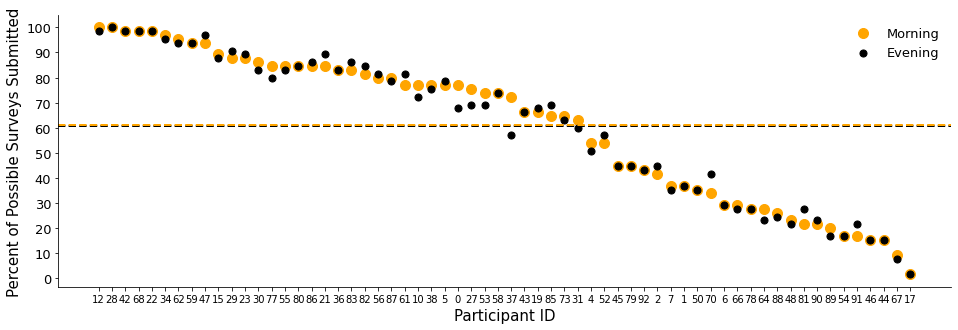

In [50]:
plot_total_submissions(by_id="redcap",save=True)

<div class="alert alert-block alert-info">
    <b>Possible Submissions</b><br> There are two participants who managed to turn in all possible morning surveys for the and one of those participants also turned in all evening surveys. The average line for the morning and evening submission averages are given and are nearly identical.
</div>

### Submissions Over Time
Here we look at the fallout and see how participation wanes during the study.

In [24]:
def plot_submission_timeline(morning=sleep_survey, evening=evening_survey, save=False):
    """
    
    """
    fig, ax = plt.subplots(figsize=(16,5))
    for df, color, size, label in zip([sleep_survey,evening_survey],["orange","black"],[100,50],["Morning","Evening"]):
        df["date"] = df.index.date
        WoY = []
        for d in df["date"]:
            WoY.append(d.isocalendar()[1])
        df["WoY"] = WoY
        counts_by_date = df.groupby("WoY").count()
        ax.scatter(counts_by_date.index,counts_by_date["beiwe"],color=color,s=size,label=label,zorder=2)

    ax.legend(frameon=False)
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)

    # x-axis
    ax.set_xticks(counts_by_date.index)
    ax.set_xticklabels(np.arange(1,len(counts_by_date)+1))
    ax.set_xlabel("Week of Study")

    # y-axis
    ax.set_ylabel("Number of Surveys Submitted")
    ax.set_yticks(np.arange(0,165,15))
    ax.set_ylim([0,200])
    if save:
        plt.savefig("../reports/figures/ema_summary/beiwe-submission_timeline_by_week-ux_s20.pdf")
    plt.show()
    plt.close()

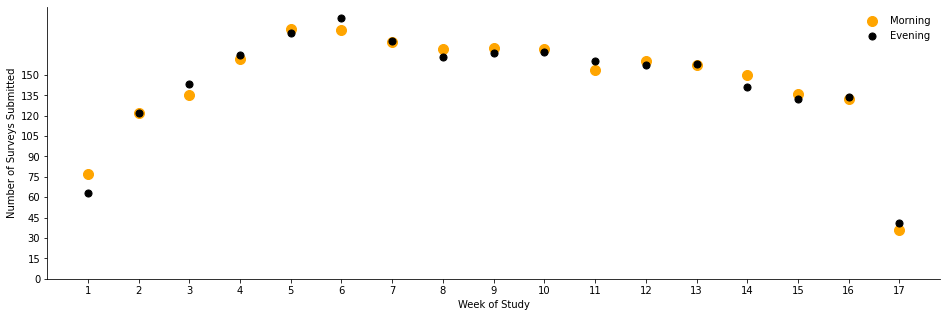

In [25]:
plot_submission_timeline(save=False)

<div class="alert alert-block alert-info">
    <b>Submission Timeline</b><br> As the study progresses, the number of surveys does seem to diminish slightly. 
</div>

### Submission Timestamps
Here we look at the actual timestamps that the surveys were submitted for both the morning and evening surveys.

In [14]:
def plot_submission_timestamp_strips(morning=sleep_survey, evening=evening_survey, save=False):
    """
    
    """
    morning["Survey"] = "Morning"
    evening["Survey"] = "Evening"
    daily_survey = morning.append(evening)
    daily_survey["hour"] = daily_survey.index.hour + daily_survey.index.minute/60
    fig, ax = plt.subplots(figsize=(6,6))
    sns.stripplot(x=daily_survey["Survey"],y=daily_survey["hour"], alpha=0.1,jitter=0.15,palette=["black","black"],ax=ax,zorder=3)
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)

    ax.set_ylim([-0.5,24.5])
    ax.set_yticks(np.arange(0,28,4))
    ax.set_ylabel("Hour of Day")

    ax.axhline(9,zorder=2,linestyle="dashed",color="cornflowerblue",alpha=0.5)
    ax.axhline(19,zorder=1,linestyle="dashed",color="cornflowerblue",alpha=0.5)
    
    if save:
        plt.savefig("../reports/figures/ema_summary/beiwe-submission_timestamp-stripplot-ux_s20.pdf")
    plt.show()
    plt.close()

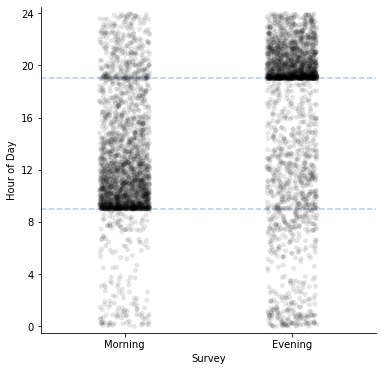

In [15]:
plot_submission_timestamp_strips(save=False)

<div class="alert alert-block alert-info">
    <b>Submission Timestamps Stripplot</b><br> Looks like the majority of students submitted the corresponding survey at the time it was sent out (9:00 for morning, 19:00 for evening). There is also a small, but noticeable increase in the morning survey submissions at 19:00 corresponding to the evening surveys.
</div>

In [16]:
def plot_submission_timestamp_histogram(morning=sleep_survey, evening=evening_survey, save=False):
    """
    
    """
    fig, axes = plt.subplots(1,2,figsize=(16,4),sharey="row")
    for df, ax, survey_type in zip([morning,evening], axes.flat, ["Morning", "Evening"]):
        df["hour"] = df.index.hour + df.index.minute/60
        n,bins,patches = ax.hist(df["hour"],bins=np.arange(0,25,1),rwidth=0.9,color="cornflowerblue",edgecolor="black",)
        ax.set_xticks(np.arange(0,25,2))

        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)

        ax.set_xlabel(survey_type)
        ax.set_ylabel("Count")
        
    plt.subplots_adjust(wspace=0.05)
    if save:
        plt.savefig("../reports/figures/ema_summary/beiwe-submission_timestamp-histogram-ux_s20.pdf")
    plt.show()
    plt.close()

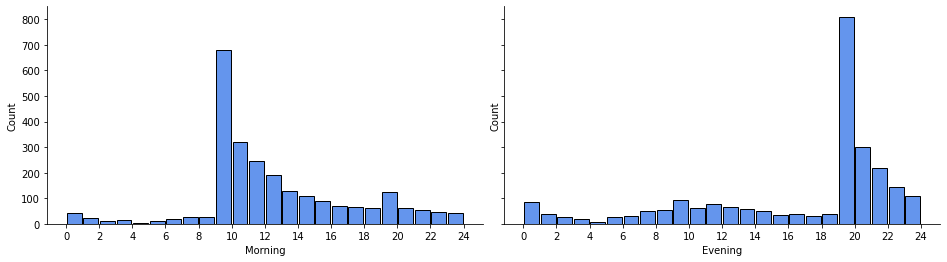

In [17]:
plot_submission_timestamp_histogram(save=False)

<div class="alert alert-block alert-info">
    <b>Submission Timestamps Histogram</b><br> Similar outcomes to the above figure
</div>

# Mood
We take a look at the mood data from the morning and evening surveys. The moods measured on these surveys are:
- content
- loneliness
- sadness
- stress
- energy level

## Summary
Starting with summarizing the data similar to the basics summarized above. 

### Aggregate Histogram

In [18]:
def label_hist(n, bins, ax):
    '''
    Labels the histogram with values above the bars
    
    Inputs:
    - n: the counts for each bin
    - bins: the actual bins limits
    
    Returns void
    '''
    k = []
    # calculate the relative frequency of each bin
    for i in range(0,len(n)):
        k.append(round((bins[i+1]-bins[i])*n[i],0))

    # plot the label/text to each bin
    for i in range(0, len(n)):
        x_pos = bins[i] + (bins[i+1] - bins[i]) / 2
        y_pos = n[i]
        label = str(k[i])[:-2] # relative frequency of each bin
        ax.text(x_pos, y_pos, label, ha='center', va='bottom')

In [21]:
def plot_mood_comparison_histogram(save=False):
    """
    Plots side-by-side histogram comparisions of the mood reportings for the morning and evening surveys. 
    """
    fig, axes = plt.subplots(5,2,figsize=(16,14),sharey='row')
    c = 0
    for df in [sleep_survey,evening_survey]:
        r = 0
        for question, color in zip(['content','stress','lonely','sad','energy'],['goldenrod','firebrick','violet','cornflowerblue','seagreen']):
            ax = axes[r,c]
            n,bins,patches = ax.hist(df[question],bins=[-0.5,0.5,1.5,2.5,3.5,4.5],rwidth=0.9,color=color,edgecolor="black")
            ax.set_xlabel(question)
            if c == 0:
                ax.set_ylabel('Frequency')
            ax.set_ylim([0,1500])

            ax.text(3.5,1000,f'n: {len(df[question])}')
            ax.text(3.5,800,f'Median: {np.median(df[question])}')

            label_hist(n, bins, ax)
            for loc in ["top","right"]:
                ax.spines[loc].set_visible(False)

            r += 1

        c += 1
        

    plt.subplots_adjust(wspace=0,hspace=0.35)
    if save:
        plt.savefig("../reports/figures/ema_summary/beiwe-all_moods-histogram-ux_s20.pdf")
    plt.show()
    plt.close()

TypeError: unsupported operand type(s) for /: 'str' and 'int'

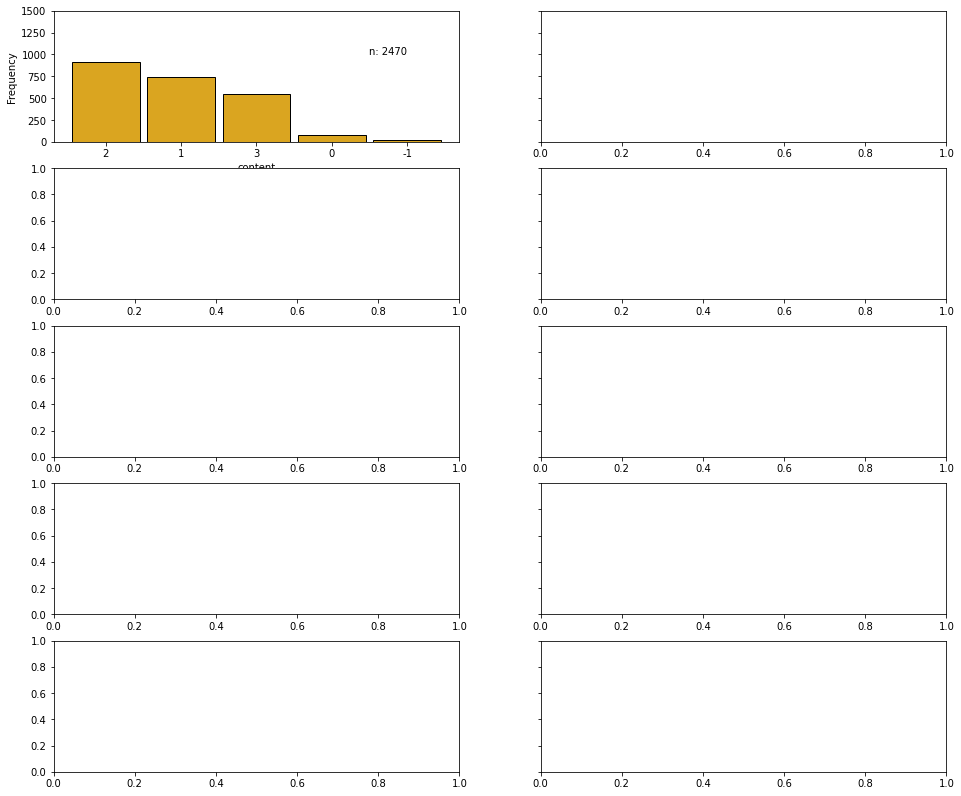

In [22]:
plot_mood_comparison_histogram(save=False)

# Sleep
Sleep portions of the survey includes:
- TST: total sleep time
- SOL: sleep onset latency
- NAW: number of awakenings
- Restful: Likert scale 0-3

## Summary
The following cells look at summarizing the results from the EMA surveys used to ask about sleep (distributed at 9:00 am every morning).

### Aggregate Histogram
Combining all participants across all question types

In [96]:
def plot_sleep_histogram(morning=sleep_survey,save=False):
    """
    
    """
    questions = ['tst','sol','naw','restful']
    xlabels = ["TST (hours)","SOL (minutes)","Number of Awakenings","Restful Score"]
    bin_list = [np.arange(0,15,1),
               np.arange(0,120,10),
               np.arange(-0.5,11.5,1),
               [-0.5,0.5,1.5,2.5,3.5]]
    titles = ["a","b","c","d"]

    fig, axes = plt.subplots(1,4,figsize=(24,4),sharey="row",gridspec_kw={'width_ratios': [5,5,5,3]})
    for question, bins, ax, xlabel, title in zip(questions, bin_list, axes.flat, xlabels, titles):
        n,bins,patches = ax.hist(morning[question],bins=bins,color="black", rwidth=0.9,align='mid')
        
        # x-axis
        ax.set_xlabel(xlabel,fontsize=15)
        plt.setp(ax.get_xticklabels(), ha="center", rotation=0, fontsize=12)
        # y-axis
        ax.set_ylim([0,1400])
        if question == "restful":
            ax.set_xticks([0,1,2,3])
        plt.setp(ax.get_yticklabels(), ha="right", rotation=0, fontsize=12)

        #ax.set_title(f'Median Response for {question}: {np.nanmedian(morning[question])}')

        #label_hist(n, bins, ax)
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
        ax.set_title(title,fontsize=16)
        
    axes[0].set_ylabel('Frequency',fontsize=15)
    plt.subplots_adjust(wspace=0.05)
    if save:
        plt.savefig("../../papers/5eea5276044b790001ee5687/figures/beiwe-sleep_metrics-histogram-ux_s20.pdf",bbox_inches="tight")
    plt.show()
    plt.close()

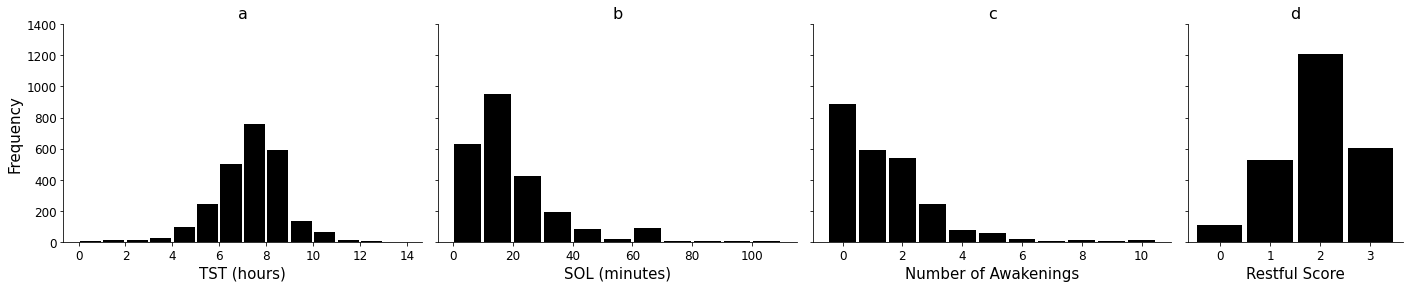

In [97]:
plot_sleep_histogram(save=True)

#### TST

In [123]:
4/len(sleep_survey["tst"])*100

0.16194331983805668

In [117]:
print("Maximum:", np.nanmax(sleep_survey['tst']))

Maximum: 12.0


In [124]:
sleep_survey[sleep_survey['tst'] == 0]

,beiwe,content,stress,lonely,sad,energy,tst,sol,naw,restful,redcap,beacon,date,WoY,Survey,hour
timestamp,,,,,,,,,,,,,,,,
2020-06-13 00:42:17,vpy1a985,2.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,50,NaN,2020-06-13,24,Morning,0.700000
2020-05-26 07:33:29,745vq78e,3,0.0,0.0,0.0,2.0,0.0,0.0,0.0,-1.0,55,5.0,2020-05-26,22,Morning,7.550000
2020-07-05 10:05:08,745vq78e,3,0.0,0.0,0.0,3.0,0.0,-1.0,-1.0,-1.0,55,5.0,2020-07-05,27,Morning,10.083333
2020-06-15 03:46:28,naucsx6v,0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,89,NaN,2020-06-15,25,Morning,3.766667


In [100]:
p_7to9 = len(sleep_survey[(sleep_survey['tst'] >= 7) & (sleep_survey['tst'] <= 9)])/len(sleep_survey['tst'])
print('Number of nights between 7 and 9 hours of sleep:\t', p_7to9*100)

p_7to8 = len(sleep_survey[(sleep_survey['tst'] >= 7) & (sleep_survey['tst'] < 8)])/len(sleep_survey['tst'])
print('Number of nights between 6 and 7 hours of sleep:\t', p_7to8*100)

p_gt_7 = len(sleep_survey[(sleep_survey['tst'] >= 7)])/len(sleep_survey['tst'])
print('Number of nights greater than 7 hours of sleep:\t\t', p_gt_7*100)

p_gt_9 = len(sleep_survey[(sleep_survey['tst'] > 9)])/len(sleep_survey['tst'])
print('Number of nights greater than 9 hours of sleep:\t\t', p_gt_9*100)

p_lt_7 = len(sleep_survey[(sleep_survey['tst'] < 7)])/len(sleep_survey['tst'])
print('Number of nights less than 7 hours of sleep:\t\t', p_lt_7*100)

Number of nights between 7 and 9 hours of sleep:	 59.4331983805668
Number of nights between 6 and 7 hours of sleep:	 30.60728744939271
Number of nights greater than 7 hours of sleep:		 62.955465587044536
Number of nights greater than 9 hours of sleep:		 3.5222672064777325
Number of nights less than 7 hours of sleep:		 36.51821862348178


#### SOL

In [103]:
cutoffs = [10,20,30,45]
for cutoff in cutoffs:
    p_lt_cutoff = sleep_survey[sleep_survey['sol'] < cutoff]
    print(f'Percent of SOL less than {cutoff} minutaes:', round(len(p_lt_cutoff)/len(sleep_survey)*100,1))

Percent of SOL less than 10 minutes: 26.7
Percent of SOL less than 20 minutes: 65.2
Percent of SOL less than 30 minutes: 82.4
Percent of SOL less than 45 minutes: 91.7


#### NAWs

In [128]:
cutoffs = [1,4]
for cutoff in cutoffs:
    p_lt_cutoff = sleep_survey[sleep_survey['naw'] <= cutoff]
    print(f'Percent of NAW less than {cutoff}:', round(len(p_lt_cutoff)/len(sleep_survey)*100,1))

Percent of NAW less than 1: 60.8
Percent of NAW less than 4: 95.4


In [130]:
sleep_survey[sleep_survey['naw'] > 4]

,beiwe,content,stress,lonely,sad,energy,tst,sol,naw,restful,redcap,beacon,date,WoY,Survey,hour
timestamp,,,,,,,,,,,,,,,,
2020-06-24 10:34:48,zdpffrox,1,2.0,0.0,1.0,0.0,8.0,15.0,5.0,1.0,0,7.0,2020-06-24,26,Morning,10.566667
2020-07-10 11:56:04,zdpffrox,1,1.0,0.0,0.0,1.0,8.0,15.0,5.0,1.0,0,7.0,2020-07-10,28,Morning,11.933333
2020-06-19 09:00:41,zdpffrox,2,2.0,1.0,1.0,1.0,5.0,7.0,5.0,1.0,0,7.0,2020-06-19,25,Morning,9.000000
2020-06-01 09:18:09,zdpffrox,1,1.0,1.0,1.0,1.0,7.0,45.0,5.0,0.0,0,7.0,2020-06-01,23,Morning,9.300000
2020-06-11 13:57:44,zdpffrox,2,2.0,0.0,0.0,2.0,9.0,15.0,5.0,3.0,0,7.0,2020-06-11,24,Morning,13.950000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-08 11:48:57,hrqrneay,0,2.0,1.0,0.0,2.0,6.0,10.0,5.0,0.0,73,NaN,2020-08-08,32,Morning,11.800000
2020-07-30 15:13:08,hrqrneay,2,2.0,1.0,0.0,1.0,4.0,10.0,5.0,0.0,73,NaN,2020-07-30,31,Morning,15.216667
2020-07-19 09:39:54,6rxyg4rp,0,2.0,1.0,1.0,0.0,8.0,5.0,8.0,3.0,80,NaN,2020-07-19,29,Morning,9.650000


#### Restful

In [132]:
for val in [0,1,2,3]:
    p = round(len(sleep_survey[sleep_survey['restful'] == val])/len(sleep_survey)*100,1)
    print(f'Percent of Participants who rated their restfullness {val}: {p}')

Percent of Participants who rated their restfullness 0: 4.3
Percent of Participants who rated their restfullness 1: 21.3
Percent of Participants who rated their restfullness 2: 48.8
Percent of Participants who rated their restfullness 3: 24.5


### Individual Histograms
A subplot of all participants with the bottom row corresponding to the aggregate.

<div class="alert alert-block alert-danger">
    A plot with 51x4 subplots seems a bit excessive to try
</div>

### Differences in the Day of the Week
Sleep metrics might vary by the day of the week, most notably the weekends.

In [ ]:
def plot_sleep_metrics_by_day(morning=sleep_survey, save=False):
    """
    Plots the mean sleep metric for the day of the week with error bars
    """
    # grouping by night sleep (survey date - 1 day)
    morning['DoW'] = (morning.index - timedelta(days=1)).strftime('%a')
    # all participants
    sleep_survey_dow = morning.groupby(['DoW']).mean()
    sleep_survey_dow = sleep_survey_dow.reindex(["Mon", "Tue", "Wed","Thu","Fri","Sat",'Sun'])
    # looping through both dataframes
    fig, axes = plt.subplots(4,1,figsize=(12,10),sharex=True)
    limits = [[5,9],[10,30],[0,3],[0,3]]
    for question, limit, ylabel, ax in zip(['tst','sol','naw','restful'],limits,['Hours','Minutes','Number','Score'],axes.flat):

        sleep_survey_dow_plot = sleep_survey_dow[sleep_survey_dow[question] >= 0]
        # Scattering for day of week
        ax.scatter(sleep_survey_dow_plot.index,sleep_survey_dow_plot[question],s=50,color='black',zorder=10)
        ax.set_title(question.upper())
        ax.set_ylim(limit)
        ax.set_ylabel(ylabel)

        # Adding 95% CI
        for day in sleep_survey['DoW'].unique():
            sleep_survey_by_day = sleep_survey[sleep_survey['DoW'] == day]
            sleep_survey_by_day = sleep_survey_by_day[sleep_survey_by_day[question] >= 0]
            ci = st.t.interval(0.95, len(sleep_survey_by_day[question])-1,
                          loc=np.mean(sleep_survey_by_day[question]),
                          scale=st.sem(sleep_survey_by_day[question]))

            ax.plot([day,day],ci,color='red',zorder=1) 
            # adding number of surveys on top figure
            if question == 'tst':
                ax.text('Mon',8,'n:   ',ha='right')
                ax.text(day,8,len(sleep_survey_by_day))
                
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)

    plt.subplots_adjust(wspace=0,hspace=0.2)
    if save:
        plt.savefig("../reports/figures/ema_summary/beiwe-sleep_metrics_by_day-scatter-ux_s20.pdf")
    plt.show()
    plt.close()

In [ ]:
plot_sleep_metrics_by_day(save=False)

# Analysis on Fully Filtered Dataset
In the following cells, we only consider the data from the fully filtered dataset - that is data from nights when we have GPS confirming pts are home, Fitbit data confirming pts are asleep, and beacon data from their environment.

## Pre-Processing
We have the nights we need to consider, so first we have to filter the overall EMA dataframe by the nights present in the fully filtered beacon data.

In [ ]:
ff_df = pd.read_csv('../data/processed/beacon-fb_ema_and_gps_filtered-ux_s20.csv',
                                 index_col="timestamp", parse_dates=["timestamp","start_time","end_time"], infer_datetime_format=True)

Adding date columns to eventually merge on

In [ ]:
ff_df['date'] = ff_df['end_time'].dt.date
sleep_survey['date'] = sleep_survey.index.date

Merging the two dataframes to get the correct number of nights.

In [ ]:
ff_sleep_survey_df = pd.DataFrame() # dataframe to hold the relevant sleep EMAs
# looping through fully filtered data and merging dataframes on common start times
for pt in ff_df['beiwe'].unique():
    ff_sleep_pt = sleep_survey[sleep_survey['beiwe'] == pt]
    ff_pt = ff_df[ff_df['beiwe'] == pt]
    ff_pt_summary = ff_pt.groupby('date').mean()
    
    ff_sleep_survey_df = ff_sleep_survey_df.append(pd.merge(left=ff_sleep_pt,right=ff_pt_summary,left_on='date',right_on='date',how='inner'))

print('Number of nights with EMAs completed:', len(ff_sleep_survey_df))
print("Number of participants:",len(ff_sleep_survey_df["beiwe"].unique()))

In [ ]:
ff_sleep_survey_df.head()

## Summary
The following cells highlight some summary information and illustrate it with figures.

In [ ]:
def plot_individual_sleep_metric_histograms(df=ff_sleep_survey_df,save=False):
    """
    
    """
    fig, axes = plt.subplots(len(df["beiwe"].unique())+1,4,figsize=(17,15),sharex="col")#,sharey="row")
    df,_ = get_number_surveys_submitted(df)
    # Plotting individual histograms
    for i, pt in enumerate(df["beiwe"].unique()):
        # getting sleep metrics per pt
        df_pt = df[df["beiwe"] == pt]
        # plotting each histogram per pt
        for j, metric, xlimits, width in zip(np.arange(4),["tst","sol","naw","restful"],[[3,12],[0,40],[0,10],[0,4]],[1,5,1,1]):
            n, bins, _ = axes[i,j].hist(df_pt[metric],bins=np.arange(xlimits[0],xlimits[1]+width,width),rwidth=0.9,color="cornflowerblue",edgecolor='black')

            axes[i,j].set_ylim([0,20])
            for loc in ["top","right"]:
                axes[i,j].spines[loc].set_visible(False)
            if j != 0:
                axes[i,j].spines["left"].set_visible(False)
                axes[i,j].set_yticks([])
    
    # Plotting aggregate histogram (last row)
    for j, metric, xlimits, width in zip(np.arange(4),["tst","sol","naw","restful"],[[3,12],[0,40],[0,10],[0,4]],[1,2,1,1]):
        n, bins, _ = axes[len(df["beiwe"].unique()),j].hist(df[metric],bins=np.arange(xlimits[0],xlimits[1]+width,width),rwidth=0.9,color="navy",edgecolor='black')
        axes[len(df["beiwe"].unique()),j].set_ylim([0,120])
        for loc in ["top","right"]:
            axes[len(df["beiwe"].unique()),j].spines[loc].set_visible(False)
        if j != 0:
            axes[len(df["beiwe"].unique()),j].spines["left"].set_visible(False)
            axes[len(df["beiwe"].unique()),j].set_yticks([])

    for k, label in enumerate(["TST (hours)","SOL (minutes)","NAW","Restful"]):
        axes[len(df["beiwe"].unique()),k].set_xlabel(label)

    plt.subplots_adjust(hspace=0.225,wspace=0.075)
    if save:
        plt.savefig("../reports/figures/ema_ff_summary/beiwe-sleep_metrics-histogram_by_pt-ux_s20.pdf")
    plt.show()
    plt.close()

In [ ]:
plot_individual_sleep_metric_histograms(save=False)

## Individual Sleep Metric Summary

In [ ]:
def plot_stacked_hist(df,var,limits,width=1,cmap='coolwarm',by_var='beiwe',save=False,save_dir='../reports/figures/ema_ff_summary/'):
    '''
    Plots a stacked histogram with each color representing a unique individual.
    
    Inputs:
    - df: dataframe of the data
    - var: string specifying the column in the dataframe to plot
    - limits: tuple representing the lower and upper bound on the x-axis
    - width: integer/float for the width of each bin
    - by_var: string specifying the column to color the stacks by
    - save: boolean to save or not
    - save_dr: string representing the location to save the figure if save is True
    
    Returns the axes with the histogram
    '''
    list_to_plot = []
    for pt in df[by_var].unique():
        temp_df = df[df[by_var] == pt]
        list_to_plot.append(temp_df[var].to_list())
    
    colors = cm.get_cmap(cmap, len(list_to_plot))
    fig, ax = plt.subplots(figsize=(8,4))
    n, bins, _ = ax.hist(list_to_plot,bins=np.arange(limits[0],limits[1]+width,width),stacked=True,rwidth=0.9,
            color=colors(np.linspace(0, 1, len(list_to_plot))),edgecolor='black')
    
    for loc in ['right','top']:
        ax.spines[loc].set_visible(False)
    ax.set_ylabel('Count')

    if save:
        plt.savefig(f'{save_dir}/{var}-stacked_hist-ux_s20.pdf')
        
    return ax
    

### TST
Total Sleep Time as reported by the participants

In [ ]:
ax = plot_stacked_hist(ff_sleep_survey_df,'tst',[2,12],by_var='beiwe')
ax.set_ylim([0,100])
ax.set_xlabel('Hours')

ax.axvline(7,color='black',linestyle='dashed',linewidth=2)
ax.axvline(9,color='black',linestyle='dashed',linewidth=2)
ax.text(8,90,"Recommended",ha='center',va='center')

#plt.savefig('../reports/figures/beiwe_sleep_duration-stacked_hist-ux_s20.pdf')
plt.show()
plt.close()

In [ ]:
p_7to9 = len(ff_sleep_survey_df[(ff_sleep_survey_df['tst'] >= 7) & (ff_sleep_survey_df['tst'] <= 9)])/len(ff_sleep_survey_df['tst'])
print('Number of nights between 7 and 9 hours of sleep:\t', p_7to9*100)

p_6to7 = len(ff_sleep_survey_df[(ff_sleep_survey_df['tst'] >= 6) & (ff_sleep_survey_df['tst'] < 7)])/len(ff_sleep_survey_df['tst'])
print('Number of nights between 6 and 7 hours of sleep:\t', p_6to7*100)

p_gt_7 = len(ff_sleep_survey_df[(ff_sleep_survey_df['tst'] >= 7)])/len(ff_sleep_survey_df['tst'])
print('Number of nights greater than 7 hours of sleep:\t\t', p_gt_7*100)

p_gt_9 = len(ff_sleep_survey_df[(ff_sleep_survey_df['tst'] > 9)])/len(ff_sleep_survey_df['tst'])
print('Number of nights greater than 9 hours of sleep:\t\t', p_gt_9*100)

p_lt_7 = len(ff_sleep_survey_df[(ff_sleep_survey_df['tst'] < 7)])/len(ff_sleep_survey_df['tst'])
print('Number of nights less than 7 hours of sleep:\t\t', p_lt_7*100)

Looking at the reported TSTs to see how participants tend to report TST.

In [ ]:
def plot_tst_raw_values(df=ff_sleep_survey_df,save=False):
    """
    
    """
    fig, ax = plt.subplots(figsize=(12,6))
    ff_sleep_survey_df.sort_values(['tst'],inplace=True)
    sns.swarmplot(df["tst"],size=5,color="cornflowerblue",ax=ax)
    for loc in ["top","right","left"]:
        ax.spines[loc].set_visible(False)

    ax.set_xticks(np.arange(3,13,1))
    ax.set_yticks([])
    ax.grid(axis="x")
    if save:
        plt.savefig("../reports/figures/ema_ff_summary/beiwe-tst-swarmplot-ux_s20.pdf")
    plt.show()
    plt.close()

In [ ]:
plot_tst_raw_values()

<div class="alert alert-block alert-success">
    Participants tend to report their TST at half-hour increments with two exceptions.
</div>

### SOL
We have SOL reported by the pts.

In [ ]:
ax = plot_stacked_hist(ff_sleep_survey_df,'sol',[0,60],width=5,by_var='beiwe')
ax.set_ylim([0,100])
ax.set_xlabel('Minutes')

ax.axvline(15,color='black',linestyle='dashed',linewidth=2)
ax.axvline(30,color='black',linestyle='dashed',linewidth=2)
ax.axvline(45,color='black',linestyle='dashed',linewidth=2)
ax.text(7.5,80,"Great",ha='center',va='center')
ax.text(22.5,80,"Good",ha='center',va='center')
ax.text(52.5,80,"Poor",ha='center',va='center')

#plt.savefig('../reports/figures/beiwe_sleep_sol-stacked_hist-ux_s20.pdf')
plt.show()
plt.close()

In [ ]:
cutoffs = [15,30,50]
for cutoff in cutoffs:
    p_lt_cutoff = ff_sleep_survey_df[ff_sleep_survey_df['sol'] < cutoff]
    print(f'Percent of SOL less than {cutoff} minutes:', round(len(p_lt_cutoff)/len(ff_sleep_survey_df)*100,1))

In [ ]:
high_sol = ff_sleep_survey_df[ff_sleep_survey_df['sol'] >= 30]
high_sol

###  Awakenings

In [ ]:
ax = plot_stacked_hist(ff_sleep_survey_df,'naw',[0,11],width=1,by_var='beiwe')
ax.set_ylim([0,100])
ax.set_xlabel('Number')

# resetting xtick-labels
ax.set_xticks(np.arange(0.5,11.5,1))
ax.set_xticklabels(np.arange(0,11,1))

ax.axvline(2,color='black',linestyle='dashed',linewidth=2)
ax.axvline(4,color='black',linestyle='dashed',linewidth=2)
ax.text(1,80,"Good",ha='center',va='center')
ax.text(5,80,"Poor",ha='center',va='center')

#plt.savefig('../reports/figures/beiwe_sleep_awakenings-stacked_hist-ux_s20.pdf')
plt.show()
plt.close()

In [ ]:
cutoffs = [2,4]
for cutoff in cutoffs:
    p_lt_cutoff = ff_sleep_survey_df[ff_sleep_survey_df['naw'] < cutoff]
    print(f'Percent of NAW less than {cutoff}:', round(len(p_lt_cutoff)/len(ff_sleep_survey_df)*100,1))

### Restful Score
On a scale of 0-3 (not at all to very much)

In [ ]:
ax = plot_stacked_hist(ff_sleep_survey_df,'restful',[0,4],width=1,by_var='beiwe')
ax.set_ylim([0,100])
ax.set_xticks([0.5,1.5,2.5,3.5])
ax.set_xticklabels(['0: Not at all','1: A little bit','2: Quite a bit','3: Very much'])
ax.set_xlabel('Response')

#plt.savefig('../reports/figures/beiwe_sleep_restful-stacked_hist-ux_s20.pdf')
plt.show()
plt.close()

In [ ]:
for val in [0,1,2,3]:
    p = round(len(ff_sleep_survey_df[ff_sleep_survey_df['restful'] == val])/len(ff_sleep_survey_df)*100,1)
    print(f'Percent of Participants who rated their restfullness {val}: {p}')

Looking at the sleep summaries for those participants who had bad restfulness scores.

In [ ]:
rest_0 = ff_sleep_survey_df[ff_sleep_survey_df['restful'] == 0]
rest_0

### Comparing Poor Sleep Results
There are a few outlying individuals and it would be interesting to see how many of these individuals are present as outliers. 

#### Bad Everything
Here we check to see if any participant was poor in all four categories.

In [ ]:
def check_sleep_results(df=ff_sleep_survey_df):
    """
    Used to check how many participants responded a certain way to each of the four sleep metric questions
    """
    print("Inequalities:\n\t1. <\n\t2. >\n\t3. <=\n\t4. >=\n\t5. ==")
    for metric in ["tst","sol","naw","restful"]:
        try:
            value = float(input(f"Value to check for {metric}: "))
            inequality = int(input("Inequality: "))
        except ValueError:
            value = -1
            inequality = -1
            
        if inequality == 1:
            print(f"{metric} < {value}")
            df = df[df[metric] < value]
        elif inequality == 2:
            print(f"{metric} > {value}")
            df = df[df[metric] > value]
        elif inequality == 3:
            print(f"{metric} <= {value}")
            df = df[df[metric] <= value]
        elif inequality == 4:
            print(f"{metric} >= {value}")
            df = df[df[metric] >= value]
        elif inequality == 5:
            print(f"{metric} = {value}")
            df = df[df[metric] == value]
        else:
            print(f"No test for {metric}")
            
    return df

In [ ]:
check_sleep_results()

In [ ]:
tst_lt6 = ff_sleep_survey_df[ff_sleep_survey_df['tst'] < 6]
print(tst_lt6.sort_values(["beacon"])['beacon'].unique())

sol_gt30 = ff_sleep_survey_df[ff_sleep_survey_df['sol'] >= 30]
print(sol_gt30.sort_values(["beacon"])['beacon'].unique())

naw_gt4 = ff_sleep_survey_df[ff_sleep_survey_df['naw'] >= 4]
print(naw_gt4.sort_values(["beacon"])['beacon'].unique())

rest_0 = ff_sleep_survey_df[ff_sleep_survey_df['restful'] == 0]
print(rest_0.sort_values(["beacon"])['beacon'].unique())


<div class="alert alert-block alert-success">
    None of the participants scored poorly in all self-report sleep metrics.
</div>

#### Bad Restful and High NAW

In [ ]:
check_sleep_results()

<div class="alert alert-block alert-success">
    Only one person reported poor restfulness scores when considering their number of awakenings.
</div>

## Predictors for Poor Restful Scores
We want to see which other self-report sleep measures are the best predictors for a poor or good restful sleep score.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

### Binary Classification - All Restful Scores
Here we consider all restful scores, but classify them as either bad (0,1) or good (2,3) to create a binary classification problem.

Massaging the data

In [ ]:
x = ff_sleep_survey_df[['tst','sol','naw']]
# rescaling SOL to hours so we have similar magnitudes
x['sol'] /= 60
y = ff_sleep_survey_df[['restful']]
y['score'] = np.where(y['restful'] < 2, 0, 1)
y.drop(['restful'],axis=1,inplace=True)

Fitting the model and getting the coefficients

In [ ]:
# SciKit
model = LogisticRegression(solver='lbfgs')
model.fit(x,y)
# StatsModels
x_sm = sm.add_constant(x)
log_reg = sm.Logit(y, x_sm).fit(method='lbfgs')

Comparing results from the two models

In [ ]:
print("\tSKL\tSM")
for sleep_metric, sklearn_c, sm_c in zip(x.columns.values,model.coef_[0],log_reg.params[1:]):
    print(f'{sleep_metric}:\t{round(sklearn_c,3)}\t{round(sm_c,3)}')
    
print(f'y-int:\t{round(model.intercept_[0],3)}\t{round(log_reg.params[0],3)}')

<div class="alert alert-block alert-info">
    The TST seems to be the greatest predictor of restful sleep scores. 
<div>

We can look at the individual contributions to the restful score but plotting a one-var logit.

In [ ]:
fig, axes = plt.subplots(3,1,figsize=(12,12))
xs = np.arange(0,14.1,0.1)
ys = {'full':[],'tst':[],'sol':[],'naw':[]}
for x_val in xs:
    ys['full'].append(1 / (1+math.exp(-1*(model.intercept_[0]+x_val*model.coef_[0][0]+x_val*model.coef_[0][1]+x_val*model.coef_[0][2]))))
    ys['tst'].append(1 / (1+math.exp(-1*(model.intercept_[0]+x_val*model.coef_[0][0]))))
    ys['sol'].append(1 / (1+math.exp(-1*(model.intercept_[0]+x_val*model.coef_[0][1]))))
    ys['naw'].append(1 / (1+math.exp(-1*(model.intercept_[0]+x_val*model.coef_[0][2]))))
    
ax = axes[0]
ax.scatter(x['tst'],y['score'],color='cornflowerblue',edgecolor='black',s=50,label='Raw Data Points')
ax.plot(xs,ys['tst'],color='firebrick',linewidth=1,label='TST Only')
ax.set_xlabel('TST (hours)')

ax = axes[1]
ax.scatter(x['sol'],y['score'],color='cornflowerblue',edgecolor='black',s=50,label='Raw Data Points')
ax.plot(xs,ys['sol'],color='firebrick',linewidth=1,label='SOL Only')
ax.set_xlim([0,2])
ax.set_xlabel('SOL (hours)')

ax = axes[2]
ax.scatter(x['naw'],y['score'],color='cornflowerblue',edgecolor='black',s=50,label='Raw Data Points')
ax.plot(xs,ys['naw'],color='firebrick',linewidth=1,label='NAW Only')
ax.set_xlabel('Number of Awakenings')

for ax in axes:
    ax.set_ylim([-0.1,1.1])
    ax.set_yticks([0,1])
    ax.set_yticklabels(["Not Restful (0/1)","Restful (3/4)"])

plt.subplots_adjust(hspace=0.2)
plt.show()
plt.close()


#### TST Only
Since TST seems to be the greatest predictor, we can create a model that takes into account only this parameter.

In [ ]:
# sklearn
model = LogisticRegression()
model.fit(x['tst'].values.reshape(-1, 1),y)

print(f'TST:', round(model.coef_[0][0],3))
print(f'Intercept: {round(model.intercept_[0],3)}')

Similar results to when we included the other sleep metrics.